<center><img src="img/torch.png" alt="drawing" width="300"/></center>

# Convolutional Neural Networks

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize':(6,3), 'legend.loc':"best", 'lines.linewidth':1.5, 'lines.marker':".", "image.cmap":"tab10", 'axes.prop_cycle':plt.cycler(color=plt.cm.tab10.colors), 'axes.formatter.useoffset':False, 'axes.titlesize': 12,'axes.labelsize': 10,'ytick.labelsize':8,'xtick.labelsize':8,'legend.fontsize': 10})
import torch
from torch import nn
import torchmetrics
from torchinfo import summary
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import EfficientNet
import mlflow
from helper_functions import train_val_loss_plot

## Data

When we are training a deep NN model, we usually train the model incrementally using an iterative optimization algorithm such as stochastic gradient descent, as we have seen in the previous notebook. In cases where the training dataset is rather small and can be loaded as a tensor into the memory, we can directly use this tensor for training as we did in the previous two notebooks. 

In typical use cases, however, when the dataset is too large to fit into the computer memory, we will need to load the data from the main storage device (for example, the hard drive or solid-state drive) in batches, that is, batch by batch. Note the use of the term *batch* instead of *mini-batch* in this chapter to stay close to the PyTorch terminology. 

In addition, we may need to construct a data-processing pipeline to apply certain transformations and preprocessing steps to our data. Applying preprocessing functions manually every time can be quite cumbersome. Luckily, PyTorch provides a special class for constructing efficient and convenient preprocessing pipelines. 

In this subsection, we will see an overview of all of these!

For this tutorial we will be using a raw sample of food images containing pizza, steak and sushi. The raw data images are inside the `data` directory and they follow the standard image classification data format that PyTorch uses:

<center><img src="img/torch_03_01.png" alt="drawing" width="250"/></center>

Before we can use our image data to train a model we have to:

1. Turn raw data into tensor objects (in our case, numerical representation of raw images) using `torch.utils.data.Dataset()` and apply transformations if needed using `torchvision.transforms`.
2. Create a `Dataloader` using the `torch.utils.data.DataLoader()` which we can be used to iterate through the individual elements in the `Dataset`.

### `Dataset`

In [2]:
def make_dataset(train_dir: str, test_dir: str, train_transform=None, test_transform=None):
    train_dataset = datasets.ImageFolder(
        root=train_dir,
        transform=train_transform,
        target_transform=None)
    
    test_dataset = datasets.ImageFolder(
        root=test_dir,
        transform=test_transform,
        target_transform=None)
    
    return train_dataset, test_dataset

In [3]:
# Write train transformer 
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), # Resize images to 64x64
    transforms.ToTensor() # Turn image into a torch.Tensor
])

# Write test transformer 
test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# Load data
train_dataset, test_dataset = make_dataset(
    train_dir="data/pizza_steak_sushi/train",
    test_dir="data/pizza_steak_sushi/test",
    train_transform=train_transform,
    test_transform=test_transform)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 170
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [4]:
# Check shape of a random image
image = train_dataset[0][0]
print(f'Image Shape: {image.shape}')

Image Shape: torch.Size([3, 64, 64])


The shape of the image tensor is `[3, 64, 64]` or more specifically: `[color_channels=3, height=64, width=64]`. Having `color_channels=3` means the image is colored. The order of our current tensor is often referred to as `CHW` (Color Channels, Height, Width). There's debate on whether images should be represented as `CHW` (color channels first) or `HWC` (color channels last). You'll also see `NCHW` and `NHWC` formats where `N` stands for number of images. For example if you have a batch_size=32, your tensor shape may be [32, 3, 64, 64]. We'll cover batch sizes later. PyTorch generally accepts `NCHW` (channels first) as the default for many operators. However, PyTorch also explains that `NHWC` (channels last) performs better and is considered best practice.

### `DataLoader`

Right now, our data is in the form of PyTorch `Datasets`. `DataLoader` turns our dataset into a Python iterable. More specifically, we want to turn our data into batches (or mini-batches). It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) all images in one hit.

A `DataLoader` is going to help us turn our Dataset's into iterables and we can customise the batch size so our model can see batch size images at a time.

In [5]:
def make_dataloader(batch_size: int, train_dataset, test_dataset):
    # Turn train dataset into iterables (batches) with Dataloader
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True)

    # Turn test dataset into iterables (batches) with Dataloader
    test_dataloader = DataLoader(dataset=test_dataset,
                                 batch_size=batch_size,
                                 shuffle=False)
    
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = make_dataloader(batch_size=1, train_dataset=train_dataset, test_dataset=test_dataset)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1743eec10>,
 <torch.utils.data.dataloader.DataLoader at 0x1065e2010>)

In [6]:
# Check length of dataloaders
print(f"Length of train_dataloader: {len(train_dataloader)} batches of 1")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of 1")

Length of train_dataloader: 450 batches of 1
Length of test_dataloader: 170 batches of 1


In [7]:
# Check shape of batch
batch, labels = next(iter(train_dataloader))
print(f'Image Shape: {batch.shape}')

Image Shape: torch.Size([1, 3, 64, 64])


The shape of the batch is `[1, 3, 64, 64]` or more specifically: `[batch_size=1, color_channels=3, height=64, width=64]`. Having `batch_size=1` means each batch contains a single image.

## Models

### Model 1: TinyVGG

In [8]:
# Build TinyVGG by copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
class TinyVGG(nn.Module):
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # Default stride value is same as kernel_size
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=hidden_units*13*13, out_features=output_shape))

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
    
tiny_vgg_0 = TinyVGG(
    input_shape=3, # Number of color channels in image data 
    hidden_units=10, # Number of hidden units
    output_shape=3) # Number of labels to predict

In [9]:
summary(tiny_vgg_0, input_size=batch.shape, col_names=["input_size", "output_size", "num_params", "trainable"], col_width=15, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
TinyVGG (TinyVGG)                        [1, 3, 64, 64]  [1, 3]          --              True
├─Sequential (conv_block_1)              [1, 3, 64, 64]  [1, 10, 30, 30] --              True
│    └─Conv2d (0)                        [1, 3, 64, 64]  [1, 10, 62, 62] 280             True
│    └─ReLU (1)                          [1, 10, 62, 62] [1, 10, 62, 62] --              --
│    └─Conv2d (2)                        [1, 10, 62, 62] [1, 10, 60, 60] 910             True
│    └─ReLU (3)                          [1, 10, 60, 60] [1, 10, 60, 60] --              --
│    └─MaxPool2d (4)                     [1, 10, 60, 60] [1, 10, 30, 30] --              --
├─Sequential (conv_block_2)              [1, 10, 30, 30] [1, 10, 13, 13] --              True
│    └─Conv2d (0)                        [1, 10, 30, 30] [1, 10, 28, 28] 910             True
│    └─ReLU (1)                          [1, 10, 28, 28] [1, 

Notice that we do not include the `Softmax` function in the end of the network. This is because this is a multiclass classification problem, and the loss function that we will use is `CrossEntropyLoss`. According to `CrossEntropyLoss` docs: *The `input` is expected to contain the unnormalized logits for each class (which do `not` need to be positive or sum to 1, in general.* In other words, the  `CrossEntropyLoss` does not expect neither the labels (coming from `torch.argmax`), nor the probabilities of the labels (coming from `softmax`) but the pre-activations of the `nn.Linear`. This is why the model does not contain the `Softmax`. However, in training, in order to compute accuracy we have to use them!


In [10]:
# Build train for training with batches since the optimizer updates the model parameters once per batch rather than once per epoch
def train(
    experiment_name: str,
    model: nn.Module,
    data: (torch.utils.data.DataLoader, torch.utils.data.DataLoader),
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    metrics: list,
    epochs: int,
    description: str = None
):
    mlflow.set_experiment(experiment_name=experiment_name)    
    with mlflow.start_run(
        run_name=f"{model.__class__.__name__} {datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}",
        description=description):
 
        train_dataloader, test_dataloader = data   
        for epoch in range(epochs):   
            model.train()
            train_loss = 0
            validation_loss = 0
            metrics_dict = {}   
            for metric in metrics:
                metrics_dict[f"train_{metric.__class__.__name__}"] = 0
                metrics_dict[f"validation_{metric.__class__.__name__}"] = 0

            # Train in batches
            for batch, (X_train, y_train) in enumerate(train_dataloader):
                y_logits = model(X_train)
                loss = loss_fn(y_logits, y_train)
                train_loss += loss.item() / len(train_dataloader) # Divide by length of train_dataloader to get average per batch
                y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
                
                for metric in metrics:
                    metrics_dict[f"train_{metric.__class__.__name__}"] += metric(y_pred, y_train).item() / len(train_dataloader)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            model.eval()
            with torch.inference_mode():
                for batch, (X_test, y_test) in enumerate(test_dataloader): 
                    y_logits = model(X_test)
                    loss = loss_fn(y_logits, y_test)
                    validation_loss += loss.item() / len(test_dataloader)
                    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
                    
                    for metric in metrics:
                        metrics_dict[f"validation_{metric.__class__.__name__}"] += metric(y_pred, y_test).item() / len(test_dataloader)

            if epoch % (epochs/10) == 0:
                print(f"Epoch: {epoch} | Train Loss: {train_loss:.3f} | Validation Loss: {validation_loss:.3f}")
            
            mlflow.log_metrics({
                "train_loss": train_loss,
                "validation_loss": validation_loss
            }, step=epoch)
            
            for metric_name, metric_value in metrics_dict.items():
                mlflow.log_metric(key=metric_name, value=metric_value, step=epoch)

        mlflow.pytorch.log_model(model, "model")
        mlflow.log_params({
            "epochs": epochs,
            "optimizer": optimizer.__class__.__name__,
            "lr": optimizer.param_groups[0]["lr"]
        })
        fig = train_val_loss_plot(run_id= mlflow.active_run().info.run_id, plot=True)
        mlflow.log_figure(fig, "plots/train_validation_loss_curves.png")

Epoch: 0 | Train Loss: 1.104 | Validation Loss: 1.097
Epoch: 1 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 2 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 3 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 4 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 5 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 6 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 7 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 8 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 9 | Train Loss: 1.099 | Validation Loss: 1.098


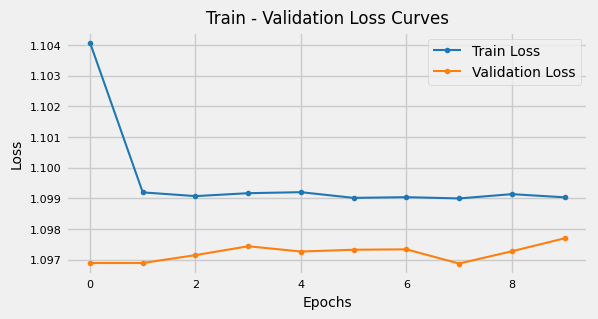

In [11]:
torch.manual_seed(42)
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metrics=[torchmetrics.Accuracy(task="multiclass", num_classes=3)]
train(experiment_name="cnn",
      description="Plain TinyVGG",
      model=model, 
      data = (train_dataloader, test_dataloader),
      loss_fn=loss_fn, 
      optimizer=optimizer, 
      metrics=metrics, 
      epochs=10)

### Model 2: Augmented TinyVGG

In model 2 we will use the exact same model but we will use some data augmentation in the train dataset.

In [12]:
# Write a train transformer including augmentation 
augmented_train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # Trivial augmentation
    transforms.ToTensor()
])

# Write a test transformer not including augmentation 
augmented_test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# Load data
augmented_train_dataset, augmented_test_dataset = make_dataset(
    train_dir="data/pizza_steak_sushi/train",
    test_dir="data/pizza_steak_sushi/test",
    train_transform=augmented_train_transform,
    test_transform=augmented_test_transform)

# Turn data to dataloaders
augmented_train_dataloader, augmented_test_dataloader = make_dataloader(
    batch_size=1, 
    train_dataset=augmented_train_dataset, 
    test_dataset=augmented_test_dataset)

Epoch: 0 | Train Loss: 1.104 | Validation Loss: 1.097
Epoch: 1 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 2 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 3 | Train Loss: 1.099 | Validation Loss: 1.098
Epoch: 4 | Train Loss: 1.099 | Validation Loss: 1.097
Epoch: 5 | Train Loss: 1.099 | Validation Loss: 1.098
Epoch: 6 | Train Loss: 1.099 | Validation Loss: 1.098
Epoch: 7 | Train Loss: 1.099 | Validation Loss: 1.098
Epoch: 8 | Train Loss: 1.099 | Validation Loss: 1.098
Epoch: 9 | Train Loss: 1.099 | Validation Loss: 1.098


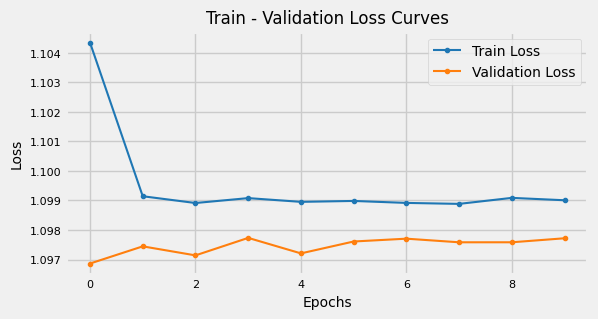

In [13]:
torch.manual_seed(42)
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metrics=[torchmetrics.Accuracy(task="multiclass", num_classes=3)]
train(experiment_name="cnn", 
      description="Plain TinyVGG with augmented dataset",
      model=model, 
      data = (augmented_train_dataloader, augmented_test_dataloader),
      loss_fn=loss_fn, 
      optimizer=optimizer, 
      metrics=metrics, 
      epochs=10)

## Transfer Learning

Transfer learning involves taking the parameters of what one model has learned on another dataset (usually called pretrained model or foundation model) and applying to our own problem.

There are 3 types of transfer learning:

* **Original Model ("As Is")**: Take a pretrained model as it is and apply it to your task without any changes. The original model remains unchanged. Helpful if you have the exact same kind of data the original model was trained on.
* **Feature Extraction**: Take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem. Most of the layers in the original model remain frozen during training and only the top 1-3 layers get updated. Helpful if you have a small amount of custom data (similar to what the original model was trained on) and want to utilise a pretrained model to get better results on your specific problem. 
* **Fine-Tuning**: Take the weights of a pretrained model and adiust (fine-tune) them to your own problem. Some, many or all of the layers in the pretrained model are updated during training. Helpful if you have a large amount of custom data and want to utilise a pretrained model and improve its underlying patterns to your specific problem.

In this subsection we will be using a pretrain model of the `torchvision.models` library called `Efficient Net B0` and we will perform `Feature Extraction` to it. On top of that, we will also play around with different experiments by training the model for a different time of epochs. 

### Model 3: Efficient Net B0 

The way of using pretrained models in PyTorch is by specifying both the model and the weights that we want to use. Let's start with the weights.

In [14]:
# Get set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

As it makes sense, a pretrained model has each own transformations of the data. As for example in the previous section we build the transform:

```
augmented_train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()])
```

for the augmented TinyVGG model, each model with its turn uses some other transfomations. 

As it makes sense, the transformations are crucial to the model either because they help in the performance (e.g. `transforms.TrivialAugmentWide(num_magnitude_bins=31)`) or because they define the input to the model (e.g. `transforms.Resize(size=(64, 64))` and `transforms.ToTensor()`). For this reason, in transfer learning when we use a pretrained model we also have to use its transformations to our data.

Torchvision provides automatic data transform creation based on the pretrained model weights you're using.

In [15]:
# Get the transforms used to create pretrained weights
efficient_net_B0_transforms = weights.transforms()
efficient_net_B0_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Now we can use this transform to our `make_dataloader` function in order to create our dataloaders in the way the model expects.

In [16]:
# Create dataset
train_dataset, test_dataset = make_dataset(
    train_dir="data/pizza_steak_sushi/train",
    test_dir="data/pizza_steak_sushi/test",
    train_transform=efficient_net_B0_transforms,
    test_transform=efficient_net_B0_transforms)

In [17]:
# Create dataloaders
train_dataloader, test_dataloader = make_dataloader(
    batch_size=32,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

In [18]:
# Load model and feed predefined weights
model = torchvision.models.efficientnet_b0(weights=weights)

In [19]:
# Create model
model = torchvision.models.efficientnet_b0(weights=weights)
summary(model=model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

As we can see the model is quite big, and all its parameters are trainable. The model is conveniently splitted in `features` and `classifier`. We can check this also with code by running `model.features` and `model.classifier`.

>The outcome of `model.features` is huge since it will return the whole architecture of TinyVGG without the classifier, so we won't actually run it.

In [20]:
# Show the part that we will change
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In order to perform future extraction we will freeze the `model.features` part so it cannot be trained, and we will first of all change the `model.classifier` to fit our needs, and then train it.

<center><img src="img/torch_03_02.png" alt="drawing" width="1200"/></center>

In [21]:
# Freeze all base layers in EfficientNetB0
for param in model.features.parameters():
    param.requires_grad = False
    
# Update classifier's head to fit our case
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # Dropout layer can stay the same
    nn.Linear(in_features=1280, out_features=3) # Feature vector stays the same but classes have change from 1000 to 3
)

# Check summary of new model
summary(model=model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Now we are ready to train our model. As we said we will train 2 of them. One with 5 epochs and one with 10 epochs.

Epoch: 0 | Train Loss: 0.964 | Validation Loss: 0.680
Epoch: 1 | Train Loss: 0.695 | Validation Loss: 0.555
Epoch: 2 | Train Loss: 0.586 | Validation Loss: 0.472
Epoch: 3 | Train Loss: 0.528 | Validation Loss: 0.431
Epoch: 4 | Train Loss: 0.434 | Validation Loss: 0.415


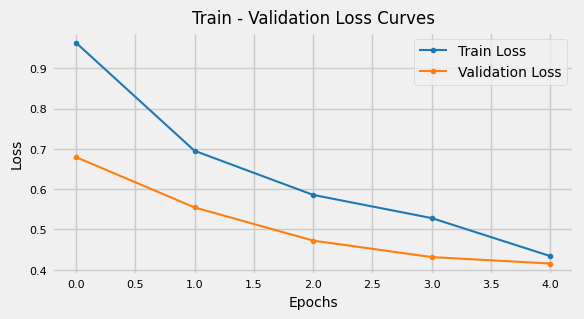

In [22]:
# Train for 5 epochs

# Load weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Instantiate new instance of Efficient Net B0
model = torchvision.models.efficientnet_b0(weights=weights)

# Freeze all base layers
for param in model.features.parameters():
    param.requires_grad = False
    
# Update classifier's head
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metrics=[torchmetrics.Accuracy(task="multiclass", num_classes=3)]
train(experiment_name="cnn", 
      description="Efficient Net B0 for 5 epochs",
      model=model, 
      data = (train_dataloader, test_dataloader),
      loss_fn=loss_fn, 
      optimizer=optimizer, 
      metrics=metrics, 
      epochs=5)

Epoch: 0 | Train Loss: 0.930 | Validation Loss: 0.630
Epoch: 1 | Train Loss: 0.671 | Validation Loss: 0.531
Epoch: 2 | Train Loss: 0.562 | Validation Loss: 0.481
Epoch: 3 | Train Loss: 0.496 | Validation Loss: 0.438
Epoch: 4 | Train Loss: 0.421 | Validation Loss: 0.396
Epoch: 5 | Train Loss: 0.448 | Validation Loss: 0.347
Epoch: 6 | Train Loss: 0.348 | Validation Loss: 0.343
Epoch: 7 | Train Loss: 0.361 | Validation Loss: 0.328
Epoch: 8 | Train Loss: 0.351 | Validation Loss: 0.312
Epoch: 9 | Train Loss: 0.324 | Validation Loss: 0.317


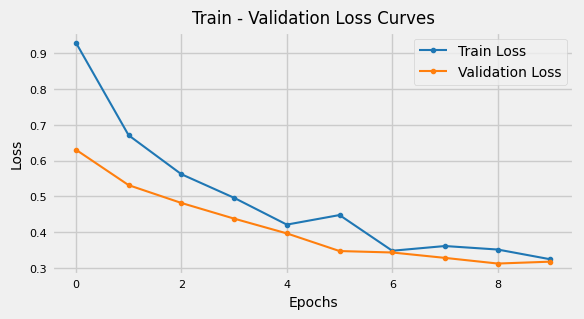

In [23]:
# Train for 10 epochs

# Load weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Instantiate new instance of Efficient Net B0
model = torchvision.models.efficientnet_b0(weights=weights)

# Freeze all base layers in EfficientNetB0
for param in model.features.parameters():
    param.requires_grad = False
     
# Update classifier's head
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metrics=[torchmetrics.Accuracy(task="multiclass", num_classes=3)]
train(experiment_name="cnn", 
      description="Efficient Net B0 for 10 epochs",
      model=model, 
      data = (train_dataloader, test_dataloader),
      loss_fn=loss_fn, 
      optimizer=optimizer, 
      metrics=metrics, 
      epochs=10)

## Paper Replication

The goal of paper replication is to turn a ML research paper into usable code. Usually we break down a ML model described in a machine learning research paper into smaller pieces:

* **Inputs**: What goes into the model.
* **Outputs**: What comes out of the model/layer/block.
* **Layers**: Takes an input, manipulates it with a function.
* **Blocks**: A collection of layers.
* **Model** or **Architecture**: A collection of blocks.

In this notebook, we're going to be replicating the [Vision Transformer (ViT) architecture/paper](https://arxiv.org/abs/2010.11929) with PyTorch.

### Model 4: Visual Transformer

Here follows a theoretical description of the model.

<center><img src="img/torch_03_03.png" alt="drawing" width="1200"/></center>

Let's start with the input layer. In most ML applications, translating raw data to tensors is the most difficult part. Here is a video explanation of how Vision Transformer model converts images to tensors, a.k.a the `Input Layer` $z_0$.

<center><video controls src="img/torch_03_04.mp4" width=480, height=320/></center>

Let's try to implement this now!

From the paper, in Table 3, we figure out that the authors perform the following transformation.

<center><img src="img/torch_03_05.png" alt="drawing" width="620"/></center>

In [24]:
IMG_SIZE=224
BATCH_SIZE=32 # In paper is 4096 but that's too large

In [25]:
vit_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

vit_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [26]:
train_dataset, test_dataset = make_dataset(
    train_dir="data/pizza_steak_sushi/train",
    test_dir="data/pizza_steak_sushi/test",
    train_transform=vit_transform,
    test_transform=vit_transform)

train_dataloader, test_dataloader = make_dataloader(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=BATCH_SIZE)

Now let's move on building the model. There are 3 main variants of ViT, based on the paper:

<center><img src="img/torch_03_06.png" alt="drawing" width="450"/></center>

In this notebook we will replicate the simplest one `ViT-Base`, however we will build it in an abstract form so it's easy to switch to another one later if we want.

In [27]:
class VisionTransformer(nn.Module):
    def __init__(self, input_shape: int, hidden_size: int, patch_size: int, num_heads: int, mlp_size: int, dropout: float, layers: int, num_classes: int):
        super().__init__()
        
        self.input_shape = input_shape
        self.hidden_size = hidden_size
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.mlp_size = mlp_size
        self.dropout = dropout
        self.layers = layers
        self.num_classes = num_classes
        
        self.batch_size = self.input_shape[0]
        self.color_channels = self.input_shape[1]
        self.height = self.input_shape[2]
        self.width = self.input_shape[3]
        self.number_of_patches = self._calculate_number_of_patches(H=self.height, W=self.width, P=self.patch_size)

        self.x_class = nn.Parameter(torch.randn(self.batch_size, 1, self.hidden_size), requires_grad=True)
        self.embedding_layer = nn.Sequential(
            nn.Conv2d(in_channels=self.color_channels, out_channels=self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size, padding=0),
            nn.Flatten(start_dim=2, end_dim=3))
        self.e_pos = nn.Parameter(torch.randn(self.batch_size, int(1+self.number_of_patches), self.hidden_size), requires_grad=True)
        
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hidden_size,
            nhead=self.num_heads,
            dim_feedforward=self.mlp_size,
            dropout=self.dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=self.layers)
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=self.hidden_size),
            nn.Linear(in_features=self.hidden_size, out_features=self.num_classes))
  
    def forward(self, x):
        z_0 = torch.hstack((self.x_class, torch.permute(self.embedding_layer(x), dims=(0,2,1)))) + self.e_pos
        z_l = self.transformer_encoder(z_0)
        y = self.classifier(z_l[:,0,:])
        return y
    
    @staticmethod
    def _calculate_number_of_patches(H,W,P):
        return (H * W) / (P**2)

> Using the already pre-made `nn.TransformerEncoderLayer` class is more efficient, however we could have actually replicated the class ourselves in the following way:
>```python
self.layer_norm = nn.LayerNorm(normalized_shape=self.hidden_size)
self.multihead_attention = nn.MultiheadAttention(
    embed_dim=self.hidden_size, 
    num_heads=self.num_heads, 
    dropout=self.msa_dropout, 
    batch_first=True)
self.mlp = nn.Sequential(
    nn.Linear(in_features=self.hidden_size, out_features=self.mlp_size),
    nn.GELU(),
    nn.Dropout(p=self.mlp_dropout),
    nn.Linear(in_features=self.mlp_size, out_features=self.hidden_size),
    nn.Dropout(p=self.mlp_dropout))
>```

In [28]:
image = next(iter(train_dataloader))[0]
image_shape = image.shape
model = VisionTransformer(input_shape=image_shape, hidden_size=768, patch_size=16, num_heads=12, mlp_size=3072, dropout=0.1, layers=12, num_classes=3)
summary(model=model,
        input_size=image_shape,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)              [32, 3, 224, 224]    [32, 3]              11,953,920           True
├─Sequential (embedding_layer)                     [32, 3, 224, 224]    [32, 768, 196]       --                   True
│    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (1)                                 [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─TransformerEncoder (transformer_encoder)         [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)            [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─TransformerEncoderLayer (1)      

We are now ready to train our model. The following code can train our model.

In [29]:
%%script false --no-raise-error 

model = VisionTransformer(input_shape=image_shape, hidden_size=768, patch_size=16, num_heads=12, mlp_size=3072, dropout=0.1, layers=12, num_classes=3)

# Taken from paper
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1)
metrics=[torchmetrics.Accuracy(task="multiclass", num_classes=3)]
train(experiment_name="cnn", 
      description="VisionTransformer self built",
      model=model, 
      data = (train_dataloader, test_dataloader),
      loss_fn=loss_fn, 
      optimizer=optimizer, 
      metrics=metrics, 
      epochs=10)

Running this code will indeed train our model. However the model is very big for my laptop to train it in its entirety, so instead I will load the pretrained version of Vision Transformer directly from PyTorch and I will freeze the base layers. That way I will trained only the classifier head and it's gonna be much faster.

#### Transfer Learning II: Vision Transformer

In [30]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

In [31]:
# Load transformers
pretrained_vit_transformers = pretrained_vit_weights.transforms()

In [32]:
# Create dataset
train_dataset, test_dataset = make_dataset(
    train_dir="data/pizza_steak_sushi/train/",
    test_dir="data/pizza_steak_sushi/train/",
    train_transform=pretrained_vit_transformers,
    test_transform=pretrained_vit_transformers)

# Create dataloader
train_dataloader, test_dataloader = make_dataloader(
    batch_size=BATCH_SIZE, 
    train_dataset=train_dataset, 
    test_dataset=test_dataset)

In [33]:
# Setup ViT model instance with pretrained weights
model = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
model.name = "vision_transformer"

# Freeze base parameters
for parameter in model.parameters():
    parameter.requires_grad = False

# Update classifier head
torch.manual_seed(42)
model.heads = nn.Linear(in_features=768, out_features=3)

# Feed random image
image = next(iter(train_dataloader))[0]
image_shape = image.shape

# Plot summary
summary(model=model, input_size=image_shape, col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Epoch: 0 | Train Loss: 0.135 | Validation Loss: 0.108
Epoch: 1 | Train Loss: 0.104 | Validation Loss: 0.089
Epoch: 2 | Train Loss: 0.096 | Validation Loss: 0.081
Epoch: 3 | Train Loss: 0.075 | Validation Loss: 0.071
Epoch: 4 | Train Loss: 0.064 | Validation Loss: 0.069


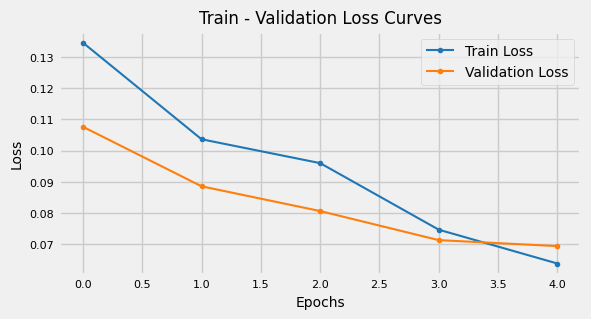

In [35]:
# Taken from paper
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1)
metrics=[torchmetrics.Accuracy(task="multiclass", num_classes=3)]
train(experiment_name="cnn", 
      description="Pretrained ViT for 10 epochs",
      model=model, 
      data = (train_dataloader, test_dataloader),
      loss_fn=loss_fn, 
      optimizer=optimizer, 
      metrics=metrics, 
      epochs=5)